In [139]:
import tensorflow as tf
import numpy as np
import pandas as pd
from IPython.display import display,Image
from scipy import ndimage
import cPickle as pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 20.0)

In [18]:

#pd.read_csv("../data/trainLabels.csv")
for image in os.listdir("../data/trainResized/"):
    name = image[:-4]
    print type(name),int(name)
    break
    

<type 'str'> 1


In [40]:
image_size = 20
pixel_depth = 255.0

def load(folder, num_images, attr):
    dataset = np.zeros(
        shape=(num_images, image_size, image_size, 3), dtype=np.float32)
    for image in os.listdir(folder):
        #print image
        image_file = os.path.join(folder,image)
        image_data = (ndimage.imread(image_file).astype(float) - pixel_depth/2)/pixel_depth
        if image_data.shape != (image_size,image_size,3):
            print image,("Unexpected image shape: %s" % str(image_data.shape) )
            continue
        if attr == "train":            
            index = int(image[:-4])-1
        else:
            index = int(image[:-4]) - 6283 - 1
        dataset[index,:,:,:] = image_data
    return dataset

#labels = np.ndarray(shape=(num_images), dtype=np.int32) 
train_dataset = load("../data/trainResized/",6283,"train")
test_dataset = load("../data/testResized/",6220,"test")


2290.Bmp Unexpected image shape: (20, 20)
284.Bmp Unexpected image shape: (20, 20)
3136.Bmp Unexpected image shape: (20, 20)
12150.Bmp Unexpected image shape: (20, 20)
7318.Bmp Unexpected image shape: (20, 20)


In [45]:

#id_class["id"]

In [116]:
train_labels[train_labels == 20]

21     20
57     20
100    20
124    20
164    20
181    20
274    20
347    20
352    20
356    20
437    20
519    20
520    20
550    20
568    20
...
5933    20
5951    20
5952    20
5964    20
5981    20
5983    20
5988    20
6020    20
6046    20
6052    20
6060    20
6081    20
6105    20
6148    20
6159    20
Name: Class, Length: 165, dtype: int64

In [132]:
def transform2number(label):
    ascii = ord(label)
    lb = ord(label) - ord("0")
    if ascii > 57 and ascii < 97:
        lb -= 7
    if ascii >= 97:
        lb -= 13
    return lb
id_class = pd.read_csv("../data/trainLabels.csv")
train_labels = id_class["Class"].apply(transform2number)

In [133]:
train_labels[train_labels > 61]
#train_labels

Series([], name: Class, dtype: int64)

In [134]:
train_labels.max()

61

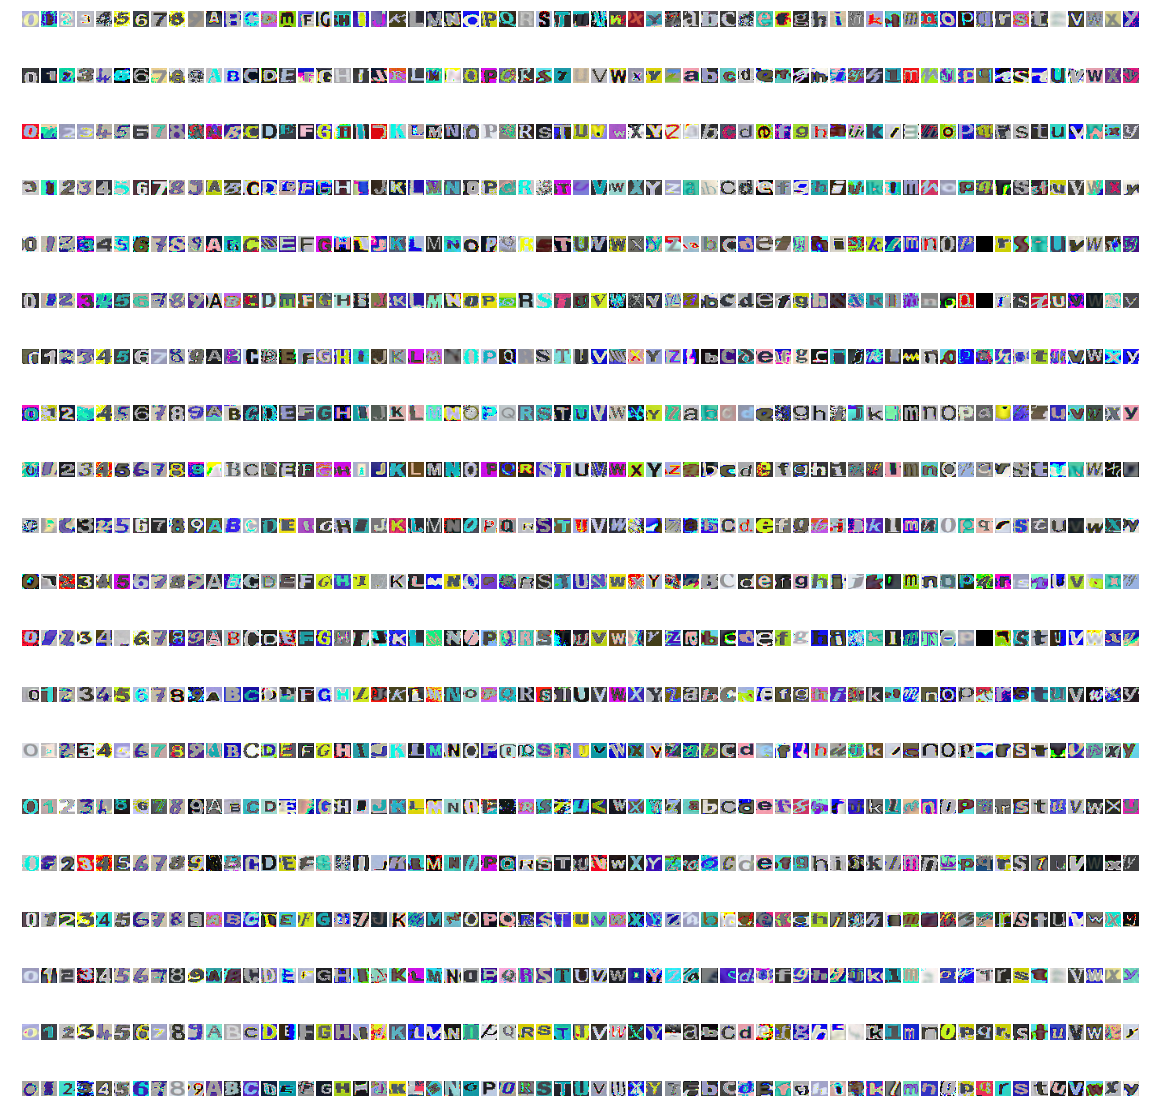

In [148]:
for label in range(0,61):
    idxs = np.random.choice(np.flatnonzero(train_labels == label),20,replace=False)
    for i,idx in enumerate(idxs):
        pos = i*61+1+label
        plt.subplot(20,61,pos)
        plt.imshow(train_dataset[idx,])
        plt.axis("off")
plt.show()

In [145]:
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
def randomize_test(dataset):
  permutation = np.random.permutation(dataset.shape[0])
  shuffled_dataset = dataset[permutation,:,:,:]
  return shuffled_dataset
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset = randomize_test(test_dataset)

In [147]:
def numexample(labels,label):
    return np.sum(labels == label)
for i in range(0,62):
    print i,"\t",numexample(train_labels,i)

0 	78
1 	65
2 	59
3 	36
4 	37
5 	41
6 	42
7 	31
8 	21
9 	36
10 	459
11 	90
12 	170
13 	165
14 	357
15 	69
16 	111
17 	152
18 	270
19 	52
20 	67
21 	168
22 	127
23 	279
24 	291
25 	131
26 	21
27 	309
28 	270
29 	257
30 	83
31 	64
32 	57
33 	43
34 	54
35 	31
36 	156
37 	25
38 	52
39 	54
40 	196
41 	28
42 	32
43 	45
44 	128
45 	20
46 	26
47 	74
48 	44
49 	125
50 	129
51 	37
52 	28
53 	123
54 	95
55 	107
56 	39
57 	23
58 	24
59 	23
60 	37
61 	20


In [165]:
train_size = 5026
valid_size = 1257

valid_dataset = train_dataset[:valid_size,:,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]
print 'Training', train_dataset.shape, train_labels.shape
print 'Validation', valid_dataset.shape, valid_labels.shape

Training (3769, 20, 20, 3) (3769, 1, 62)
Validation (1257, 20, 20, 3) (1257, 1, 62)


In [150]:
pickle_file = 'Resized.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    #'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

In [152]:
statinfo = os.stat(pickle_file)
print 'Compressed pickle size:', statinfo.st_size


Compressed pickle size: 60115595


In [153]:
def similar(dataset1,dataset2):
    print dataset2.shape
    nexm,nrow,ncol = dataset1.shape
    dataset1 = np.reshape(dataset1[0:5000,],(5000,nrow*ncol))
    nexm,nrow,ncol = dataset2.shape
    dataset2 = np.reshape(dataset2[0:1000,],(1000,1,nrow*ncol))
    dataset = dataset1 - dataset2
    return dataset.T

def overlap(S):
    #m = np.mean(S)
    return np.sum(S == 0)
STrainVal = similar(train_dataset,valid_dataset)
print "train Val overlap: ",overlap(STrainVal)
SValTest  = similar(valid_dataset,test_dataset)
print "Val Test overlap: ", overlap(SValTest)

(1257, 20, 20, 3)


ValueError: too many values to unpack

In [155]:
image_size = 20
num_labels = 62
num_channels = 3 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
#test_dataset, test_labels = reformat(test_dataset, test_labels)
print 'Training set', train_dataset.shape, train_labels.shape
print 'Validation set', valid_dataset.shape, valid_labels.shape
#print 'Test set', test_dataset.shape, test_labels.shape

Training set (5026, 20, 20, 3) (5026, 1, 62)
Validation set (1257, 20, 20, 3) (1257, 1, 62)


In [156]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [161]:
batch_size = 20
patch_size = 4
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size / 4 * image_size / 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    print data.get_shape(),layer1_weights.get_shape(),conv.get_shape()
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    print hidden.get_shape(),layer2_weights.get_shape(),conv.get_shape()
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

(20, 20, 20, 3) (4, 4, 3, 16) (20, 10, 10, 16)
(20, 10, 10, 16) (4, 4, 16, 16) (20, 5, 5, 16)
(1257, 20, 20, 3) (4, 4, 3, 16) (1257, 10, 10, 16)
(1257, 10, 10, 16) (4, 4, 16, 16) (1257, 5, 5, 16)
(6220, 20, 20, 3) (4, 4, 3, 16) (6220, 10, 10, 16)
(6220, 10, 10, 16) (4, 4, 16, 16) (6220, 5, 5, 16)


In [164]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  for step in xrange(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    print batch_labels.shape
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels)
  #print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)

Initialized
(20, 1, 62)


ValueError: Cannot feed value of shape (20, 1, 62) for Tensor u'Placeholder_1:0', which has shape '(20, 62)'